# Google Colab 한글 폰트 설치

In [1]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

Selecting previously unselected package fonts-nanum.
(Reading database ... 123621 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

['NanumBarunGothic'] 11.0


- 테스트

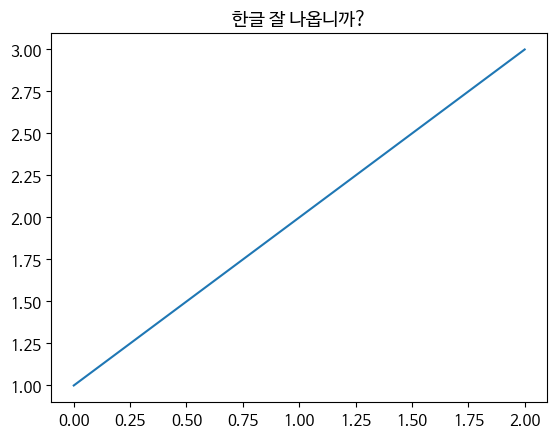

In [3]:
plt.plot([1, 2, 3])
plt.title("한글 잘 나옵니까?")
plt.show()

# Google Colab과 드라이브 연동

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 라이브러리 불러오기

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose, STL

# 시계열 시각화 맛보기

## matplotlib 설정

In [7]:
plt.rcParams['axes.unicode_minus'] = False

## 데이터 불러오기

In [8]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/2024/알파코/time_series/data/'

df = pd.read_csv(DATA_PATH + 'jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


## 데이터 시각화

In [10]:
df['year'] = pd.DatetimeIndex(df['date']).year
df

,date,data,year
0,1960-01-01,0.71,1960
1,1960-04-01,0.63,1960
2,1960-07-02,0.85,1960
3,1960-10-01,0.44,1960
4,1961-01-01,0.61,1961
...,...,...,...
79,1979-10-01,9.99,1979
80,1980-01-01,16.20,1980
81,1980-04-01,14.67,1980
82,1980-07-02,16.02,1980


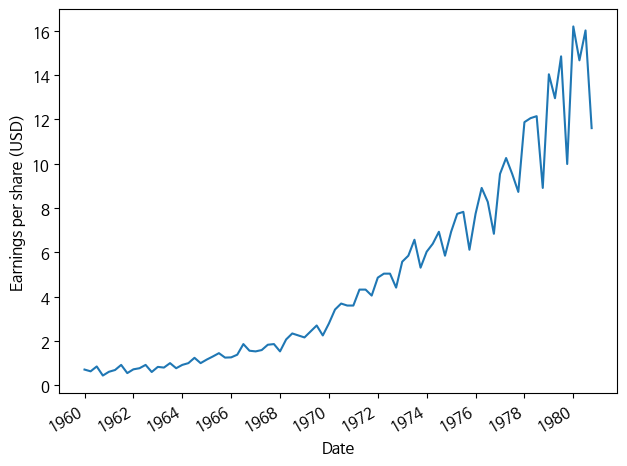

In [11]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 시계열 분해 및 시각화

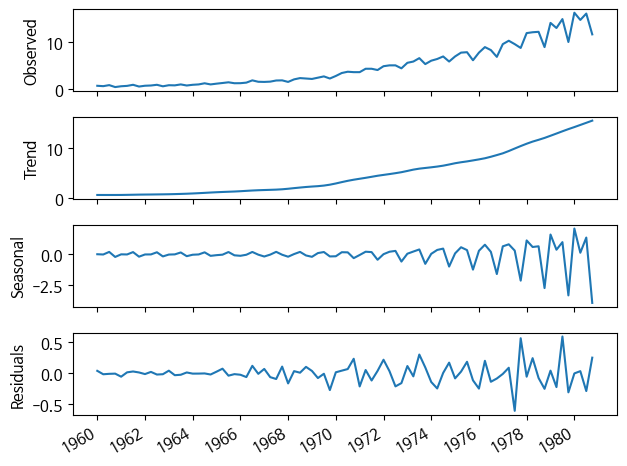

In [12]:
advanced_decomposition = STL(df.data, period=4).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 데이터 복원
- 원래 상태로 복원

In [13]:
df = df.drop('year', axis = 1)
df

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02


# 베이스라인 모델 설계





## 예측구간 설정
- 훈련데이터 : 1960년부터 시작하여 1979년 말까지
- 예측데이터 : 1980년

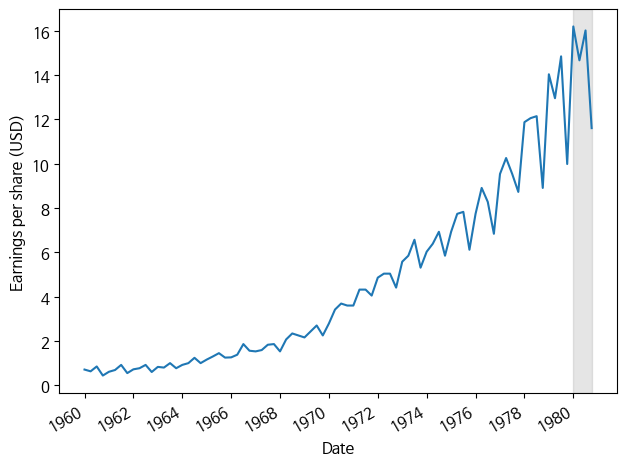

In [14]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 평가지표
- MAPE 함수 만들기

In [15]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 데이터셋 분리

In [16]:
train = df[:-4]
test = df[-4:]

## 모델 1 (지난 19년도 데이터)


In [17]:
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [18]:
df.tail()

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [19]:
# 모델 학습
historical_mean = np.mean(train['data'])
historical_mean

4.308499987499999

In [20]:
# 모델 예측
test.loc[:, 'pred_mean'] = historical_mean
test

<ipython-input-20-d5e75cf1dd7a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = historical_mean


,date,data,pred_mean
80,1980-01-01,16.20,4.3085
81,1980-04-01,14.67,4.3085
82,1980-07-02,16.02,4.3085
83,1980-10-01,11.61,4.3085


In [21]:
mape_hist_mean = mape(test['data'], test['pred_mean'])
mape_hist_mean # 약 70% 차이 발생

70.00752579965119

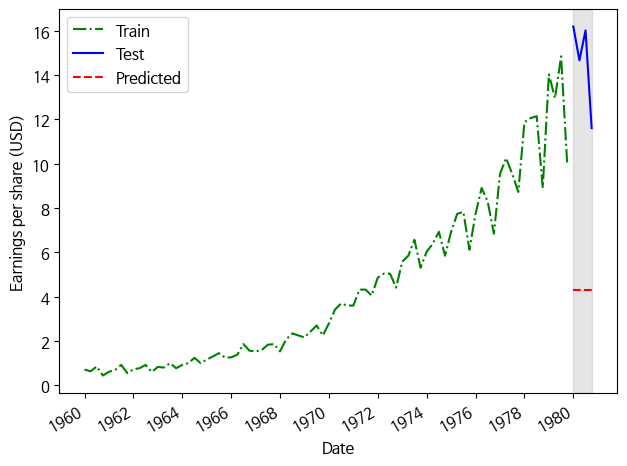

In [22]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 모델 2 (작년 1년 데이터)

In [23]:
last_year_mean = np.mean(train['data'][-4:])
test.loc[:, 'pred_last_yr_mean'] = last_year_mean
test.head()

<ipython-input-23-f962d2742928>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_yr_mean'] = last_year_mean


,date,data,pred_mean,pred_last_yr_mean
80,1980-01-01,16.20,4.3085,12.96
81,1980-04-01,14.67,4.3085,12.96
82,1980-07-02,16.02,4.3085,12.96
83,1980-10-01,11.61,4.3085,12.96


In [24]:
mape_last_year_mean = mape(test['data'], test['pred_last_yr_mean'])
mape_last_year_mean # 15.60% 차이 발생

15.5963680725103

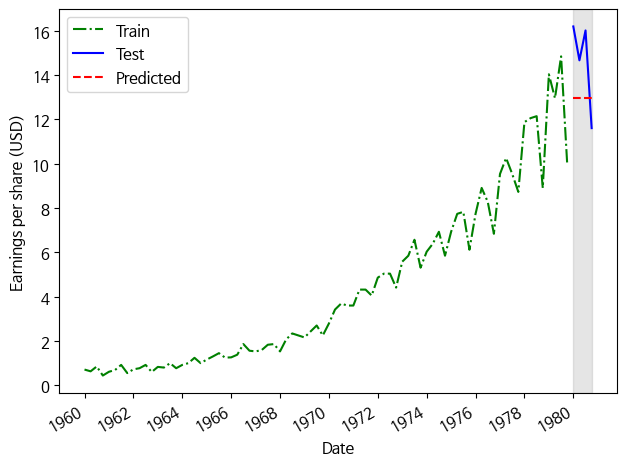

In [25]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last_yr_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 모델 1과 2 비교

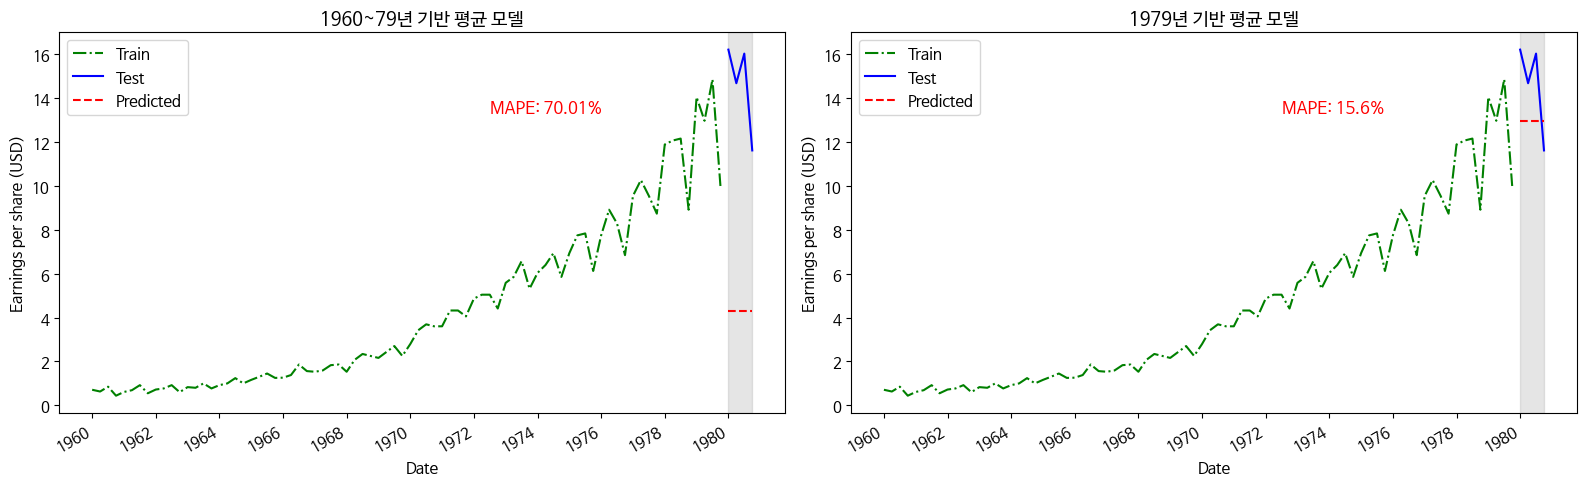

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))

# Plot for 1960~79 mean model
ax[0].plot(train['date'], train['data'], 'g-.', label='Train')
ax[0].plot(test['date'], test['data'], 'b-', label='Test')
ax[0].plot(test['date'], test['pred_mean'], 'r--', label='Predicted')
ax[0].set_title('1960~79년 기반 평균 모델')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Earnings per share (USD)')
ax[0].axvspan(80, 83, color='#808080', alpha=0.2)
ax[0].legend(loc=2)
ax[0].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[0].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_hist_mean, 2)}%", color='red', fontsize=12)

# Plot for 1979 mean model
ax[1].plot(train['date'], train['data'], 'g-.', label='Train')
ax[1].plot(test['date'], test['data'], 'b-', label='Test')
ax[1].plot(test['date'], test['pred_last_yr_mean'], 'r--', label='Predicted')
ax[1].set_title('1979년 기반 평균 모델')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Earnings per share (USD)')
ax[1].axvspan(80, 83, color='#808080', alpha=0.2)
ax[1].legend(loc=2)
ax[1].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[1].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_last_year_mean, 2)}%", color='red', fontsize=12)

# Format date labels and save the figure
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('earnings_per_share_forecast.png')  # Save the figure
plt.show()

## 계절적 예측 구현
- 주기적 패턴 확인

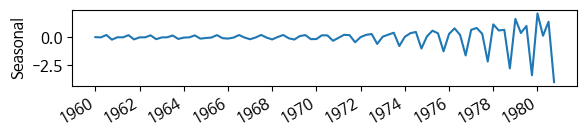

In [27]:
fig, ax = plt.subplots(figsize=(6, 1.5))

ax.plot(advanced_decomposition.seasonal)
ax.set_ylabel('Seasonal')
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

- 단순한 계절적 예측 방법
  + 마지막으로 측정된 주기가 미래에도 반복된다는 것
  + 1979년 첫 번째 분기의 EPS를 사용하여 1980년 첫 번째 분기의 값 예측
- 측정결과 가장 낮은 MAPE 기록 (11.56%)

In [28]:
test.loc[:, 'pred_last_season'] = train['data'][-4:].values
mape_naive_seasonal = mape(test['data'], test['pred_last_season'])
mape_naive_seasonal

<ipython-input-28-ee263d27c05d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_season'] = train['data'][-4:].values


11.561658552433654

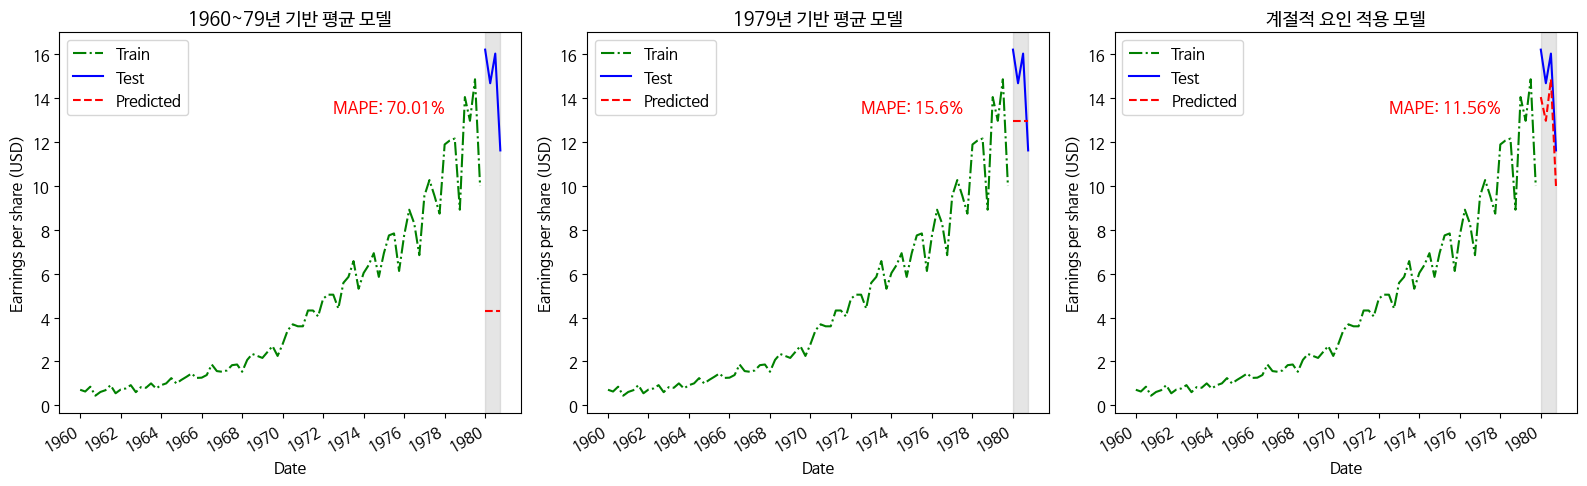

In [29]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 5))

# Plot for 1960~79 mean model
ax[0].plot(train['date'], train['data'], 'g-.', label='Train')
ax[0].plot(test['date'], test['data'], 'b-', label='Test')
ax[0].plot(test['date'], test['pred_mean'], 'r--', label='Predicted')
ax[0].set_title('1960~79년 기반 평균 모델')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Earnings per share (USD)')
ax[0].axvspan(80, 83, color='#808080', alpha=0.2)
ax[0].legend(loc=2)
ax[0].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[0].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_hist_mean, 2)}%", color='red', fontsize=12)

# Plot for 1979 mean model
ax[1].plot(train['date'], train['data'], 'g-.', label='Train')
ax[1].plot(test['date'], test['data'], 'b-', label='Test')
ax[1].plot(test['date'], test['pred_last_yr_mean'], 'r--', label='Predicted')
ax[1].set_title('1979년 기반 평균 모델')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Earnings per share (USD)')
ax[1].axvspan(80, 83, color='#808080', alpha=0.2)
ax[1].legend(loc=2)
ax[1].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[1].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_last_year_mean, 2)}%", color='red', fontsize=12)

# Plot for 1979 mean model
ax[2].plot(train['date'], train['data'], 'g-.', label='Train')
ax[2].plot(test['date'], test['data'], 'b-', label='Test')
ax[2].plot(test['date'], test['pred_last_season'], 'r--', label='Predicted')
ax[2].set_title('계절적 요인 적용 모델')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Earnings per share (USD)')
ax[2].axvspan(80, 83, color='#808080', alpha=0.2)
ax[2].legend(loc=2)
ax[2].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[2].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_naive_seasonal, 2)}%", color='red', fontsize=12)

# Format date labels and save the figure
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('earnings_per_share_forecast.png')  # Save the figure
plt.show()

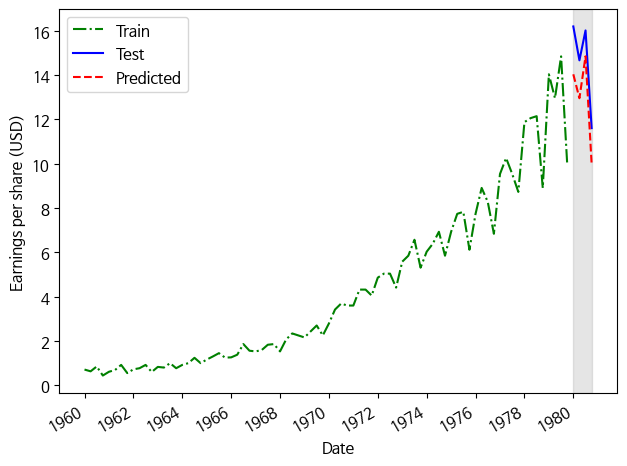

In [30]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last_season'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 각 모델 성능 비교

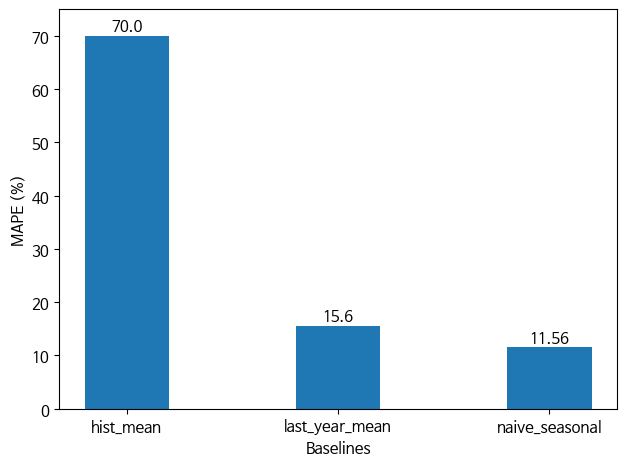

In [31]:
fig, ax = plt.subplots()

x = ['hist_mean', 'last_year_mean', 'naive_seasonal']
y = [70.00, 15.60, 11.56]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Baselines')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 75)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(value), ha='center')

plt.tight_layout()

# 확률보행 따라가보기


## 데이터 불러오기

In [32]:
df = pd.read_csv(DATA_PATH + 'GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


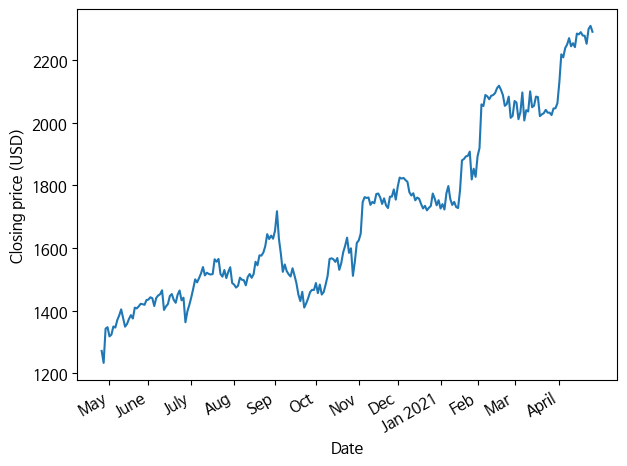

In [33]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

plt.xticks(
    [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235],
    ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2021', 'Feb', 'Mar', 'April'])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 확률보행 시각화

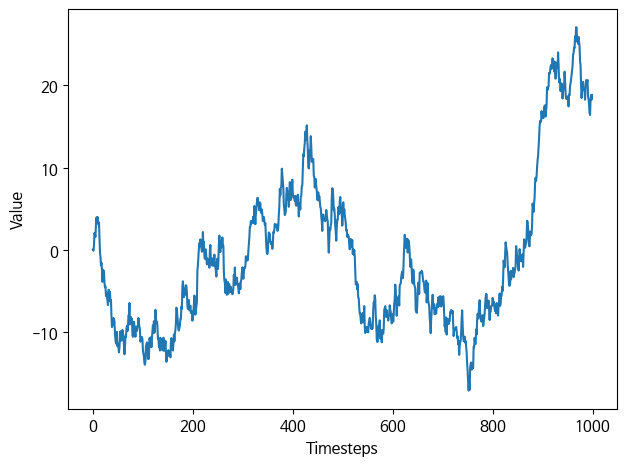

In [34]:
np.random.seed(42)

steps = np.random.standard_normal(1000)
steps[0]=0

random_walk = np.cumsum(steps)

fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

## 정상성 테스트

### 정상 vs 비정상 시계열 시각화

In [35]:
def simulate_process(is_stationary: bool) -> np.array:
    np.random.seed(42)
    process = np.empty(400)

    if is_stationary:
        alpha = 0.5
        process[0] = 0
    else:
        alpha = 1
        process[0] = 10

    for i in range(400):
        if i+1 < 400:
            process[i+1] = alpha*process[i] + np.random.standard_normal()
        else:
            break

    return process

In [36]:
stationary = simulate_process(True)
non_stationary = simulate_process(False)

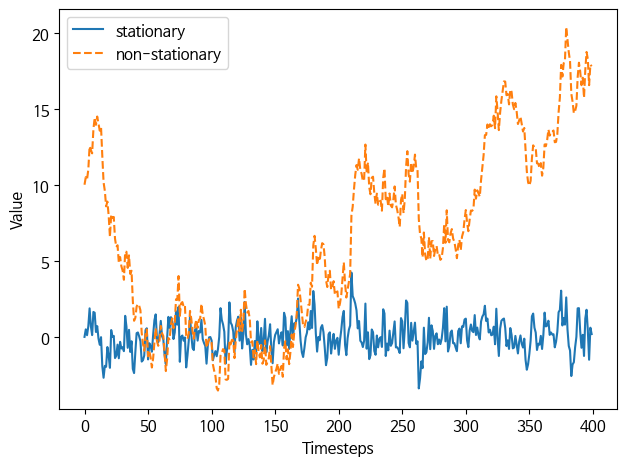

In [37]:
fig, ax = plt.subplots()

ax.plot(stationary, linestyle='-', label='stationary')
ax.plot(non_stationary, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.legend(loc=2)

plt.tight_layout()
plt.show()

### 평균이 일정한가?

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


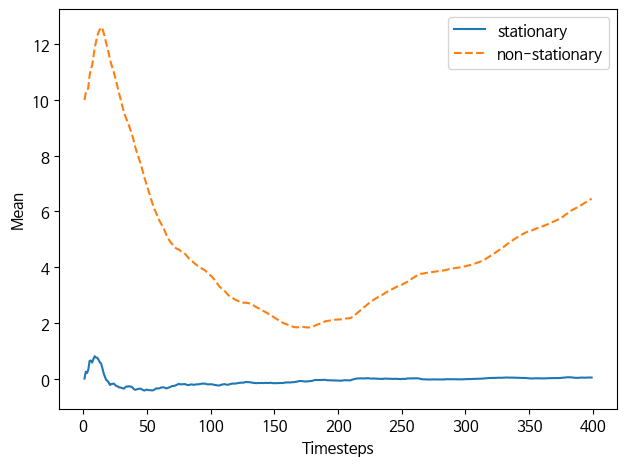

In [38]:
def mean_over_time(process: np.array) -> np.array:
    mean_func = []

    for i in range(len(process)):
        mean_func.append(np.mean(process[:i]))

    return mean_func

stationary_mean = mean_over_time(stationary)
non_stationary_mean = mean_over_time(non_stationary)

fig, ax = plt.subplots()

ax.plot(stationary_mean, label='stationary')
ax.plot(non_stationary_mean, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean')
ax.legend(loc=1)

plt.tight_layout()
plt.show()

### 분산이 일정한가?

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


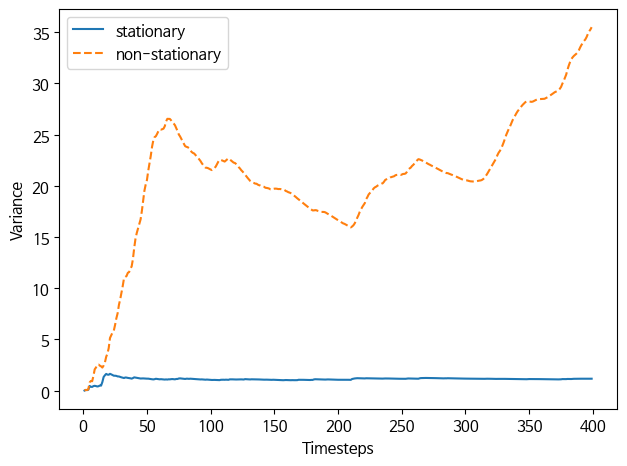

In [39]:
def var_over_time(process: np.array) -> np.array:
    var_func = []

    for i in range(len(process)):
        var_func.append(np.var(process[:i]))

    return var_func

stationary_var = var_over_time(stationary)
non_stationary_var = var_over_time(non_stationary)

fig, ax = plt.subplots()

ax.plot(stationary_var, label='stationary')
ax.plot(non_stationary_var, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Variance')
ax.legend(loc=2)

plt.tight_layout()
plt.show()

### 3개 그래프 합치기

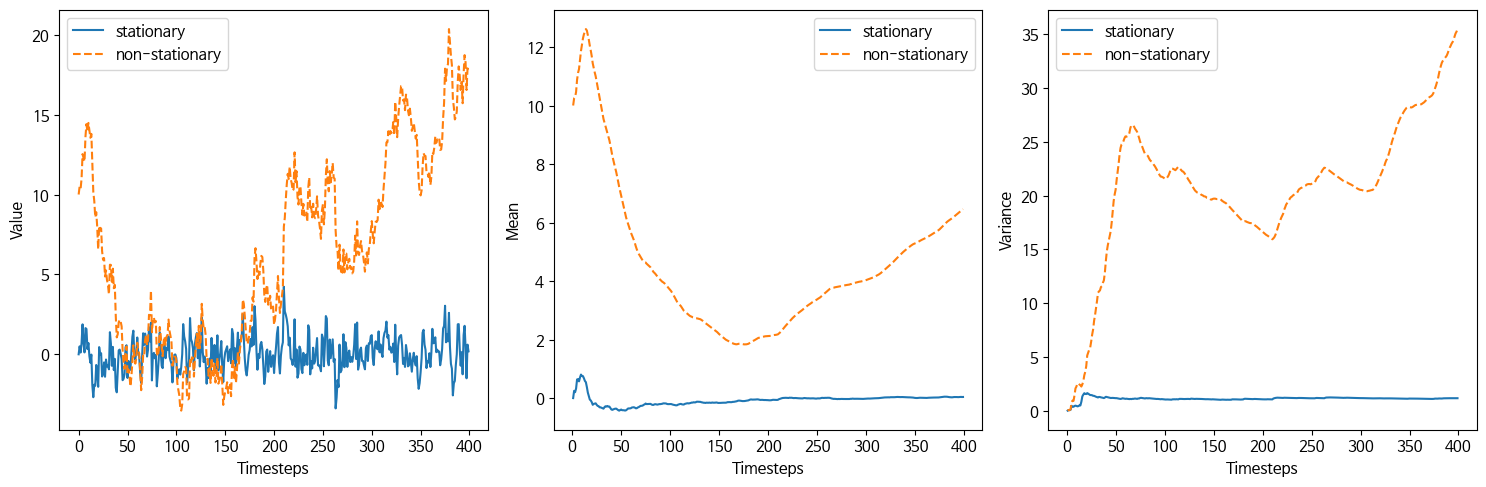

In [40]:
fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))

ax[0].plot(stationary, linestyle='-', label='stationary')
ax[0].plot(non_stationary, linestyle='--', label='non-stationary')
ax[0].set_xlabel('Timesteps')
ax[0].set_ylabel('Value')
ax[0].legend(loc=2)

ax[1].plot(stationary_mean, label='stationary')
ax[1].plot(non_stationary_mean, linestyle='--', label='non-stationary')
ax[1].set_xlabel('Timesteps')
ax[1].set_ylabel('Mean')
ax[1].legend(loc=1)

ax[2].plot(stationary_var, label='stationary')
ax[2].plot(non_stationary_var, linestyle='--', label='non-stationary')
ax[2].set_xlabel('Timesteps')
ax[2].set_ylabel('Variance')
ax[2].legend(loc=2)

plt.tight_layout()
plt.show()

# 자기상관관계

### 확률보행 확인
- ADF 테스트 적용
  + 귀무가설 : 시계열은 비정상## 확률보행 확인
  - ADF 테스트 적용
    + 귀무가설 : 주어진 시계열 데이터는 비정상 시계열이다
    + 대립가설 : 주어진 시계열 데이터는 비정상 시계열이 아니다

In [42]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.965952487691875
p-value: 0.7654789696692581


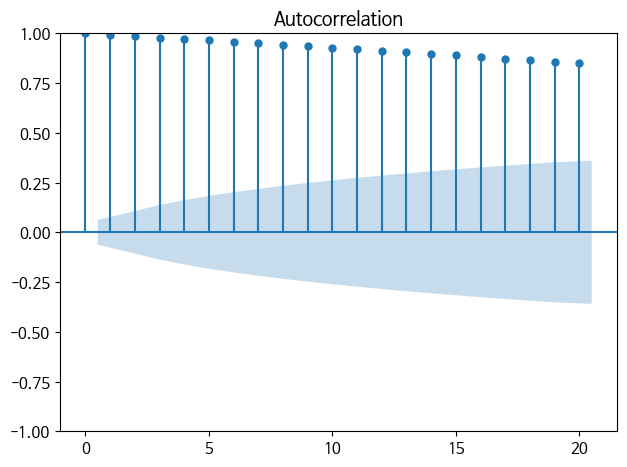

In [44]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(random_walk, lags=20);

plt.tight_layout()
plt.show()

## 차분진행 후 시각화

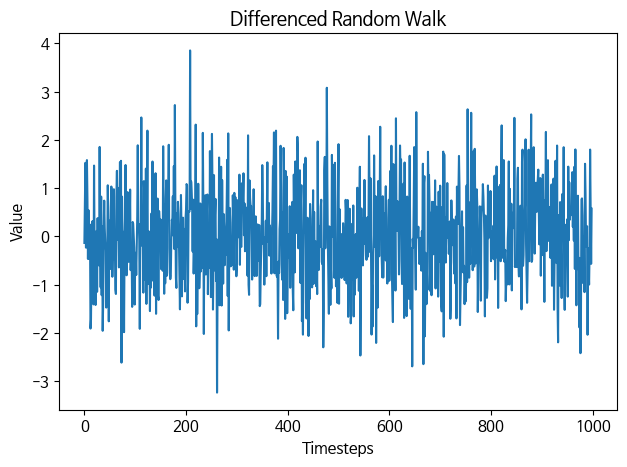

In [45]:
diff_random_walk = np.diff(random_walk, n=1)
plt.plot(diff_random_walk)
plt.title('Differenced Random Walk')
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [46]:
ADF_result = adfuller(diff_random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -31.789310857560594
p-value: 0.0


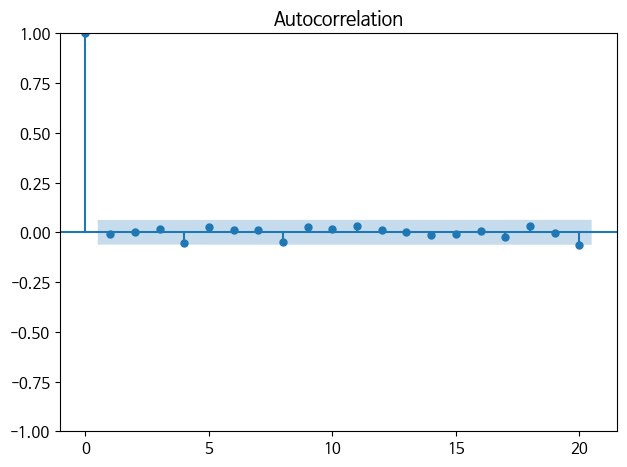

In [47]:
plot_acf(diff_random_walk, lags=20);

plt.tight_layout()
plt.show()

## Google 데이터 확인

In [48]:
df = pd.read_csv(DATA_PATH + 'GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


In [50]:
GOOGL_ADF_result = adfuller(df['Close'])

print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print(f'p-value: {GOOGL_ADF_result[1]}')

ADF Statistic: 0.16025048664771302
p-value: 0.9699419435913057


In [51]:
diff_close = np.diff(df['Close'], n=1)

In [52]:
GOOGL_diff_ADF_result = adfuller(diff_close)

print(f'ADF Statistic: {GOOGL_diff_ADF_result[0]}')
print(f'p-value: {GOOGL_diff_ADF_result[1]}')

ADF Statistic: -5.303439704295234
p-value: 5.3865309614545585e-06


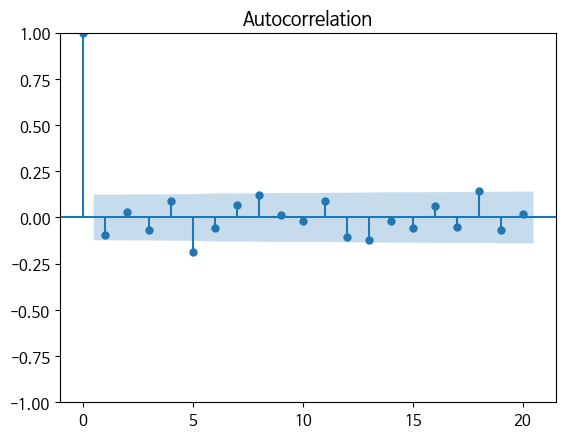

In [53]:
plot_acf(diff_close, lags=20);

# Google 주식 예측

In [54]:
df = pd.DataFrame({'value': random_walk})

train = df[:800]
test = df[800:]

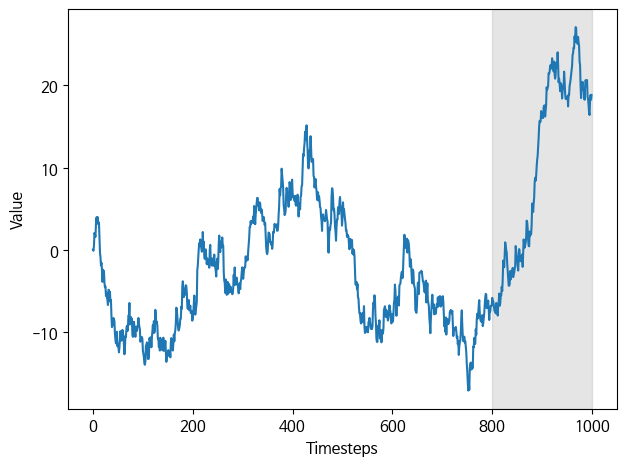

In [55]:
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.tight_layout()
plt.show()

## 과거의 평균 활용

In [57]:
mean = np.mean(train.value)
test.loc[:, 'pred_mean'] = mean
test.head()

,value,pred_mean
800,-5.876664,-3.677206
801,-6.392708,-3.677206
802,-6.296588,-3.677206
803,-6.758863,-3.677206
804,-7.193359,-3.677206


In [58]:
last_value = train.iloc[-1].value
test.loc[:, 'pred_last'] = last_value
test.head()

<ipython-input-58-1a12198482c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last'] = last_value


,value,pred_mean,pred_last
800,-5.876664,-3.677206,-6.814947
801,-6.392708,-3.677206,-6.814947
802,-6.296588,-3.677206,-6.814947
803,-6.758863,-3.677206,-6.814947
804,-7.193359,-3.677206,-6.814947


## 표류 기법 활용
- 마지막으로 측정된 값으로 예측하는 방법 수정
- 시간의 흐름에 따른 값의 증가나 감소 허용
- 훈련 집합의 첫번째 값과 마지막 값 사이의 기울기 계산한 뒤, 이 기울기를 미래에 단순히 외삽

In [59]:
deltaX = 800 - 1
deltaY = last_value - 0
drift = deltaY / deltaX
x_vals = np.arange(801, 1001, 1)
pred_drift = drift * x_vals
test.loc[:, 'pred_drift'] = pred_drift
test.head()

<ipython-input-59-937327b3f775>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_drift'] = pred_drift


,value,pred_mean,pred_last,pred_drift
800,-5.876664,-3.677206,-6.814947,-6.832006
801,-6.392708,-3.677206,-6.814947,-6.840536
802,-6.296588,-3.677206,-6.814947,-6.849065
803,-6.758863,-3.677206,-6.814947,-6.857594
804,-7.193359,-3.677206,-6.814947,-6.866124


## 예측 시각화 구현

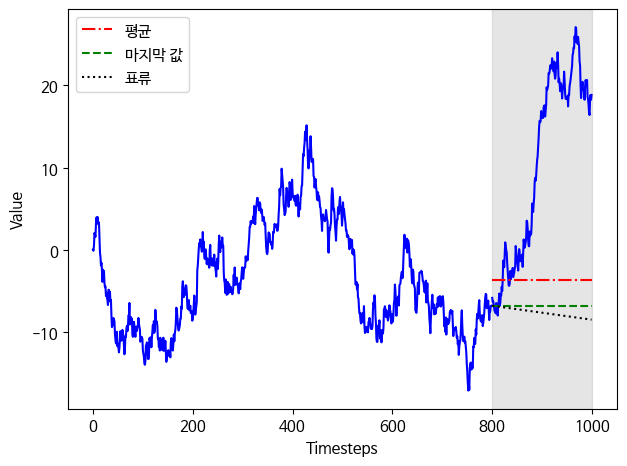

In [61]:
fig, ax = plt.subplots()

ax.plot(train.value, 'b-')
ax.plot(test['value'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='평균')
ax.plot(test['pred_last'], 'g--', label='마지막 값')
ax.plot(test['pred_drift'], 'k:', label='표류')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

## 예측모형 평가

In [62]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

326.50277395297474 425.1726033055617 466.2172769077409


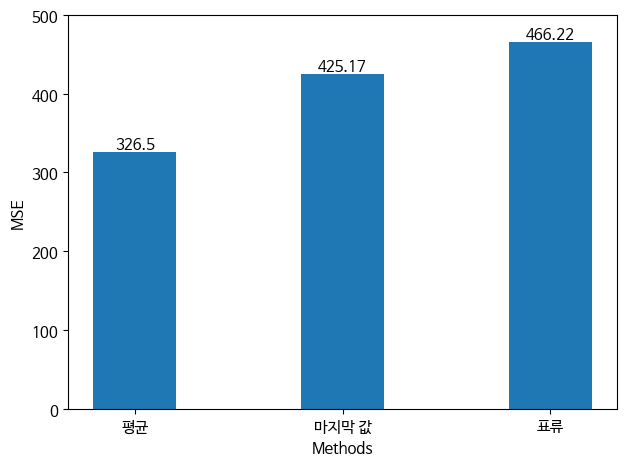

In [64]:
fig, ax = plt.subplots()

x = ['평균', '마지막 값', '표류']
y = [mse_mean, mse_last, mse_drift]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 500)

for index, value in enumerate(y):
    plt.text(x=index, y=value+5, s=str(round(value, 2)), ha='center')

plt.tight_layout()
plt.show()

## 다음 시간 단계 예측

In [65]:
df_shift = df.shift(periods=1)
df_shift.head()

,value
0,NaN
1,0.000000
2,-0.138264
3,0.509424
4,2.032454


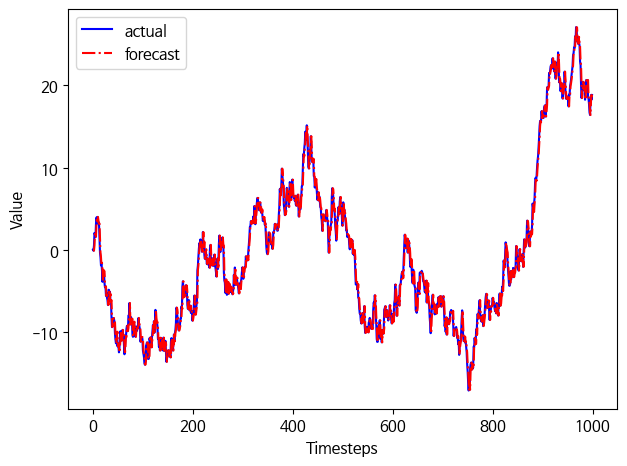

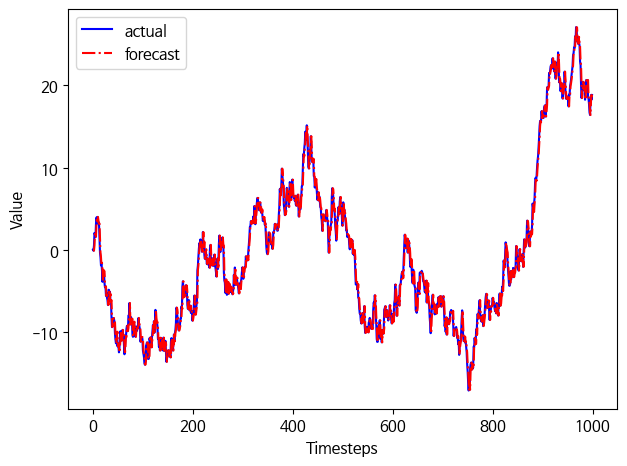

In [66]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.show(0)

In [67]:
mse_one_step = mean_squared_error(test['value'], df_shift[800:])
mse_one_step

0.9256876651440581

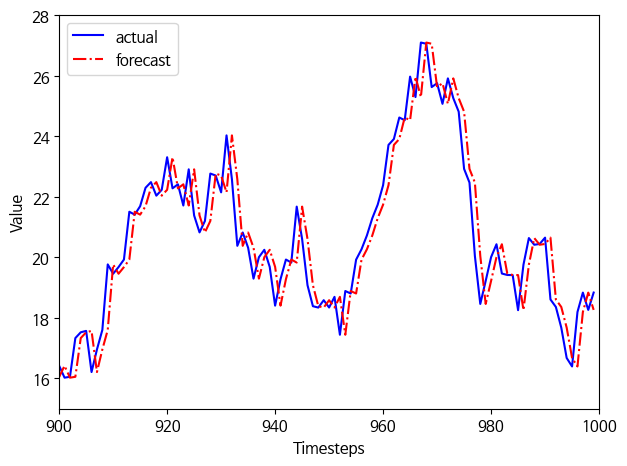

In [68]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlim(900, 1000)
ax.set_ylim(15, 28)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.show()